# Writing Kanji with an MDN-RNN

- What kind of data can be predicted by a mixture density network RNN?
    - Sequential data that is _continuous_, not categorical.
- Drawing data is a good example, tend to want high resolution in 2 dimensions to draw.
    - not practical for categories
- Let's try modelling some _drawing_ data using an MDN-RNN.
- In this case we will use a dataset of Kanji

This example is similar to hardmaru's Kanji tutorial and the original Sketch-RNN repository:

- http://blog.otoro.net/2015/12/28/recurrent-net-dreams-up-fake-chinese-characters-in-vector-format-with-tensorflow/
- https://github.com/hardmaru/sketch-rnn

- The idea is to learn how to draw kanji characters from a dataset of vector representations. 
- This means learning how to move a pen in 2D space.
- The data consists of a sequence of pen movements (loations in 2D) and whether the pen is up or down.
- In this example, we will use one 3D MDN to model everything!

We will end up with a system that can invent "new" kanji---but it won't know how to stop drawing! E.g.:

![Kanji Test 1](figures/kanji_test_1.png)


In [1]:
from context import * # imports the MDN layer 
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib widget

# Only for GPU use:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
from tensorflow.keras import backend as K

2024-06-14 13:37:40.132640: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-14 13:37:40.231908: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 13:37:40.741282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 13:37:40.741336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 13:37:40.866232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

### First download and process the dataset.

In [2]:
# Train from David Ha's Kanji dataset from Sketch-RNN: https://github.com/hardmaru/sketch-rnn-datasets
# Other datasets in "Sketch 3" format should also work.
import urllib.request
url = 'https://github.com/hardmaru/sketch-rnn-datasets/raw/master/kanji/kanji.rdp25.npz'  
urllib.request.urlretrieve(url, './kanji.rdp25.npz')  

('./kanji.rdp25.npz', <http.client.HTTPMessage at 0x7f0c9a57ce10>)

### Dataset:

Includes about 11000 handwritten kanji characters divied into training, validation, and testing sets.

For creative purposes, we may not need the validation or testing sets, and can just focus on the training set.

In [3]:
with np.load('./kanji.rdp25.npz', allow_pickle=True) as data:
    train_set = data['train']
    valid_set = data['valid']
    test_set = data['test']
    
print("Training kanji:", len(train_set))
print("Validation kanji:", len(valid_set))
print("Testing kanji:", len(test_set))

Training kanji: 10358
Validation kanji: 600
Testing kanji: 500


### Looking at one example

Let's have a look at one example from the training data.

- Each example is a sequence of pen movements with three numbers:
    - The movement of the pen in the x-direction (left-right)
    - The movement of the pen in the y-direction (up-down)
    - Whether the pen is raised, or lowered touching the paper (1 = up, 0 = down).
    

In [4]:
# Have a look at the data.
example = train_set[99]
print("Shape:", example.shape)
print(example[:20])

Shape: (121, 3)
[[ 2.98828125e-01  5.28808594e-01  0.00000000e+00]
 [ 6.37207031e-01  2.72900391e+00  0.00000000e+00]
 [ 4.15000916e-02  2.96630859e+00  0.00000000e+00]
 [-3.72764587e-01  2.72597656e+01  0.00000000e+00]
 [-5.94665527e-01  1.10971680e+01  1.00000000e+00]
 [ 2.51953125e+00 -4.29375000e+01  0.00000000e+00]
 [ 9.25781250e+00 -1.05731201e+00  0.00000000e+00]
 [ 1.35036621e+01 -2.17260742e+00  0.00000000e+00]
 [ 3.00000000e+00 -2.99835205e-02  1.00000000e+00]
 [-1.47187500e+01  2.82031250e+00  0.00000000e+00]
 [ 9.49707031e-01  1.52001953e+00  0.00000000e+00]
 [-2.50007629e-01  3.85087891e+01  1.00000000e+00]
 [-1.28515625e+01 -2.49531250e+01  0.00000000e+00]
 [ 2.24399414e+01 -3.54003906e+00  0.00000000e+00]
 [ 3.00000000e+00 -2.00347900e-02  1.00000000e+00]
 [-2.58437500e+01  1.58906250e+01  0.00000000e+00]
 [ 2.37370605e+01 -2.64471436e+00  0.00000000e+00]
 [ 2.20068359e+00  6.46820068e-02  1.00000000e+00]
 [-2.62031250e+01  1.79375000e+01  0.00000000e+00]
 [ 2.34306641e+

### Reconstructing a training example

Lets try to plot this example:

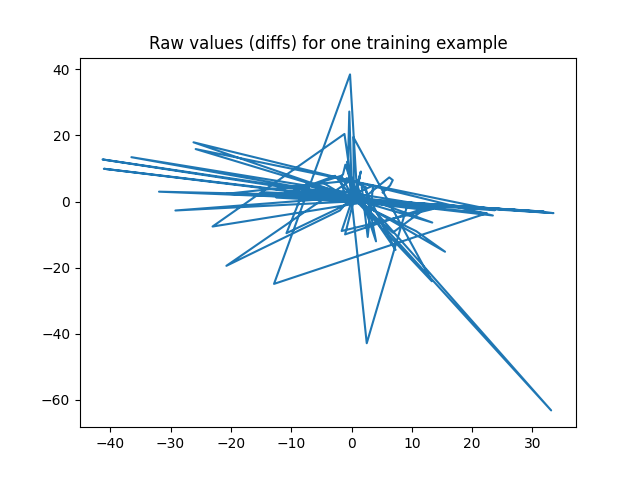

In [5]:
plt.plot(example.T[0], example.T[1])
plt.title("Raw values (diffs) for one training example")
plt.show()

- That didn't work very well as we were just plotting the raw values
    - (the difference between each pen movement)
- We can transform these into paper locations by using the `cumsum()` function.
- This will add each value to the sum of the previous in the array.

Here's a proper sketch:

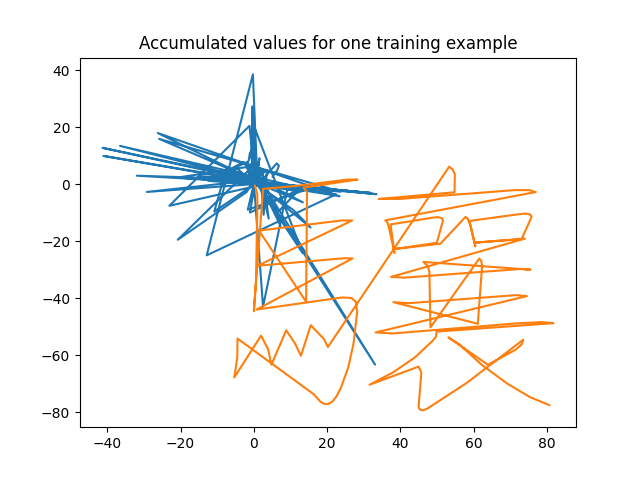

In [6]:
plt.plot(example.T[0].cumsum(), -1 * example.T[1].cumsum())
plt.title("Accumulated values for one training example")
plt.show()

(Note that this sketch ignores the pen's touching or not value.)

### Setup an MDN RNN

So let's set up an MDN RNN to learn how to create similar drawings.

Our RNN will have the following settings:

- 2 RNN layers.
- 256 LSTM units per RNN layer
- a 3-dimensional mixture layer with 10 mixtures.
- train for sequence length of 30.
- training for 100 epochs with a batch size of 64.

Here's a diagram:

![Diagram of the Kanji MDN-RNN](figures/kanji-mdn-diagram.png)



Why do we need a 3D mixture model?

- One dimension for `pen-X`, one for `pen-Y`, and one for `pen-UpDown`
- `pen-UpDown` isn't exactly a real number (it's either 0 or 1), but we can _make a simpler model_ by just adding another MDN dimension.
- When doing predictions, we can just round the `pen-UpDown` value up to 1 or down to 0. Easy!

In [7]:
# Training Hyperparameters:
SEQ_LEN = 30
BATCH_SIZE = 64
# Originally had 100 epochs and 256 hidden units, reduced for testing
HIDDEN_UNITS = 128
EPOCHS = 18
SEED = 2345  # set random seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
OUTPUT_DIMENSION = 3
NUMBER_MIXTURES = 10

# Sequential model
model = keras.Sequential()

# Add two LSTM layers, make sure the input shape of the first one is (?, 30, 3)
model.add(keras.layers.LSTM(HIDDEN_UNITS, batch_input_shape=(None,SEQ_LEN,OUTPUT_DIMENSION), return_sequences=True))
model.add(keras.layers.LSTM(HIDDEN_UNITS))

# Here's the MDN layer, need to specify the output dimension (3) and number of mixtures (10)
model.add(mdn.MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES))

# Now we compile the MDN RNN - need to use a special loss function with the right number of dimensions and mixtures.
model.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer=keras.optimizers.legacy.Adam())

# Let's see what we have:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           67584     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 mdn (MDN)                   (None, 70)                9030      
                                                                 
Total params: 208198 (813.27 KB)
Trainable params: 208198 (813.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Process the Data and Train the Model

- Chop up the data into slices of the correct length, generate `X` and `y` for the training process.
- Very similar process to the previous RNN examples!
- We end up with 330000 examples - a pretty healthy dataset.

In [8]:
# Functions for slicing up data
def slice_sequence_examples(sequence, num_steps):
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
    return xs

def seq_to_singleton_format(examples):
    xs = []
    ys = []
    for ex in examples:
        xs.append(ex[:-1])
        ys.append(ex[-1])
    return (xs,ys)

# Prepare training data as X and Y.
slices = []
for seq in train_set:
    slices +=  slice_sequence_examples(seq, SEQ_LEN+1)
X, y = seq_to_singleton_format(slices)

X = np.array(X)
y = np.array(y)

print("Number of training examples:")
print("X:", X.shape)
print("y:", y.shape)

Number of training examples:
X: (330546, 30, 3)
y: (330546, 3)


## Do the training!

- We're not going to train in the tutorial!
- These settings take about 220 seconds per epoch, about 6 hours for the whole training run.

In [9]:
# Fit the model
history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[keras.callbacks.TerminateOnNaN()])

Epoch 1/18
5165/5165 [==============================] - 301s 57ms/step - loss: 7.8801
Epoch 2/18
5165/5165 [==============================] - 313s 61ms/step - loss: 5.1331
Epoch 3/18
5165/5165 [==============================] - 265s 51ms/step - loss: 3.3380
Epoch 4/18
5165/5165 [==============================] - 297s 57ms/step - loss: 2.2274
Epoch 5/18
5165/5165 [==============================] - 299s 58ms/step - loss: 1.7241
Epoch 6/18
5165/5165 [==============================] - 308s 60ms/step - loss: 1.8567
Epoch 7/18
5165/5165 [==============================] - 312s 60ms/step - loss: 1.1434
Epoch 8/18
5165/5165 [==============================] - 307s 59ms/step - loss: 1.1083
Epoch 9/18
5165/5165 [==============================] - 306s 59ms/step - loss: 3.4820
Epoch 10/18
5165/5165 [==============================] - 305s 59ms/step - loss: 3.0932
Epoch 11/18
5165/5165 [==============================] - 278s 54ms/step - loss: 2.1320
Epoch 12/18
5165/5165 [=============================

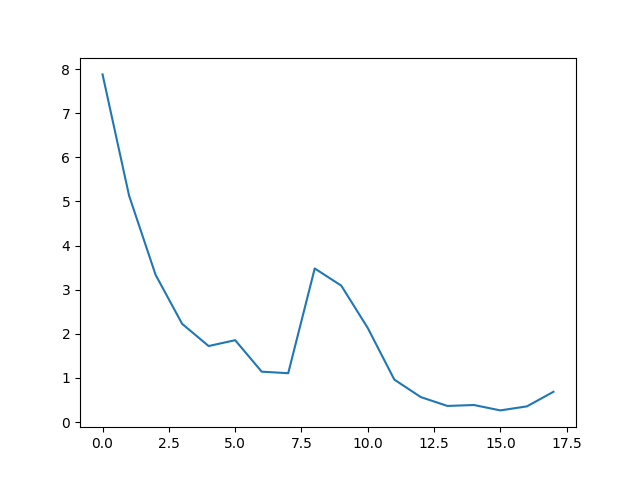

In [10]:
plt.figure()
plt.plot(history.history['loss'])
plt.show()

In [13]:
model_name = "MDN-RNN-kanji-generation-model-large.keras"

In [14]:
model.save("MDN-RNN-kanji-generation-model-large.keras")

In [ ]:
# Loads the model from a saved file. For testing this is hugely preferred as training is very expensive
model = tf.keras.models.load_model(model_name, custom_objects={'MDN': mdn.MDN, 'mdn_loss_func': mdn.get_mixture_loss_func(1, NUMBER_MIXTURES)})

In [15]:
model.save('MDN-RNN-kanji-generation-weights-large.h5')  # creates a HDF5 file of the model

/home/ninjatimtam/.cache/pypoetry/virtualenvs/keras-mdn-layer-Fodlja9D-py3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Try out the model! Generate some Kanji!

We need to create a decoding model with batch size 1 and sequence length 1.

In [16]:
# Decoding Model
# Same as training model except for dimension and mixtures.

decoder = keras.Sequential()
decoder.add(keras.layers.LSTM(HIDDEN_UNITS, batch_input_shape=(1,1,OUTPUT_DIMENSION), return_sequences=True, stateful=True))
decoder.add(keras.layers.LSTM(HIDDEN_UNITS, stateful=True))
decoder.add(mdn.MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES))
decoder.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer=keras.optimizers.Adam())
decoder.summary()

decoder.load_weights('MDN-RNN-kanji-generation-weights.h5') # load weights independently from file

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (1, 1, 128)               67584     
                                                                 
 lstm_3 (LSTM)               (1, 128)                  131584    
                                                                 
 mdn_1 (MDN)                 (1, 70)                   9030      
                                                                 
Total params: 208198 (813.27 KB)
Trainable params: 208198 (813.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Generating drawings

- First need some helper functions to view the output.

In [17]:
def zero_start_position():
    """A zeroed out start position with pen down"""
    out = np.zeros((1, 1, 3), dtype=np.float32)
    out[0, 0, 2] = 1 # set pen down.
    return out

def generate_sketch(model, start_pos, num_points=100):
     return None

def cutoff_stroke(x):
    return np.greater(x,0.5) * 1.0

def plot_sketch(sketch_array):
    """Plot a sketch quickly to see what it looks like."""
    sketch_df = pd.DataFrame({'x':sketch_array.T[0],'y':sketch_array.T[1],'z':sketch_array.T[2]})
    sketch_df.x = sketch_df.x.cumsum()
    sketch_df.y = -1 * sketch_df.y.cumsum()
    # Do the plot
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(111)
    #ax1.scatter(sketch_df.x,sketch_df.y,marker='o', c='r', alpha=1.0)
    # Need to do something with sketch_df.z
    ax1.plot(sketch_df.x,sketch_df.y,'r-')
    plt.show()

## SVG Drawing Function

Here's Hardmaru's Drawing Functions from _write-rnn-tensorflow_. Big hat tip to Hardmaru for this!

Here's the source: https://github.com/hardmaru/write-rnn-tensorflow/blob/master/utils.py


In [18]:
# Hardmaru's Drawing Functions from write-rnn-tensorflow
# Big hat tip
# Here's the source:
# https://github.com/hardmaru/write-rnn-tensorflow/blob/master/utils.py

import svgwrite
from IPython.display import SVG, display

def get_bounds(data, factor):
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)

    return (min_x, max_x, min_y, max_y)

def draw_strokes(data, factor=1, svg_filename='sample.svg'):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1

    abs_x = 25 - min_x
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)

    command = "m"

    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        lift_pen = data[i, 2]
        p += command + str(x) + "," + str(y) + " "

    the_color = "black"
    stroke_width = 1

    dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))

    dwg.save()
    display(SVG(dwg.tostring()))

1/1 [==============================] - 0s 15ms/step


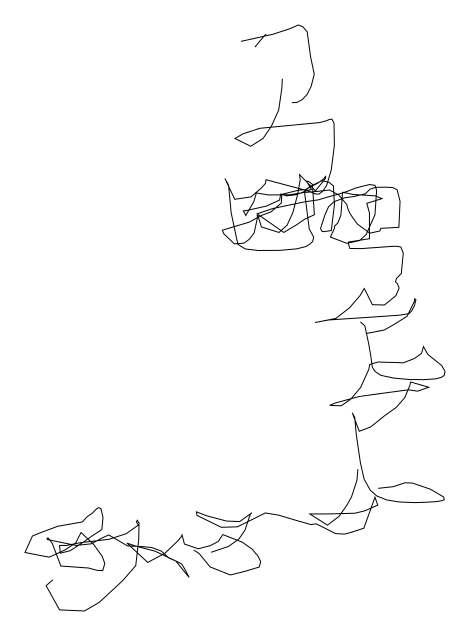

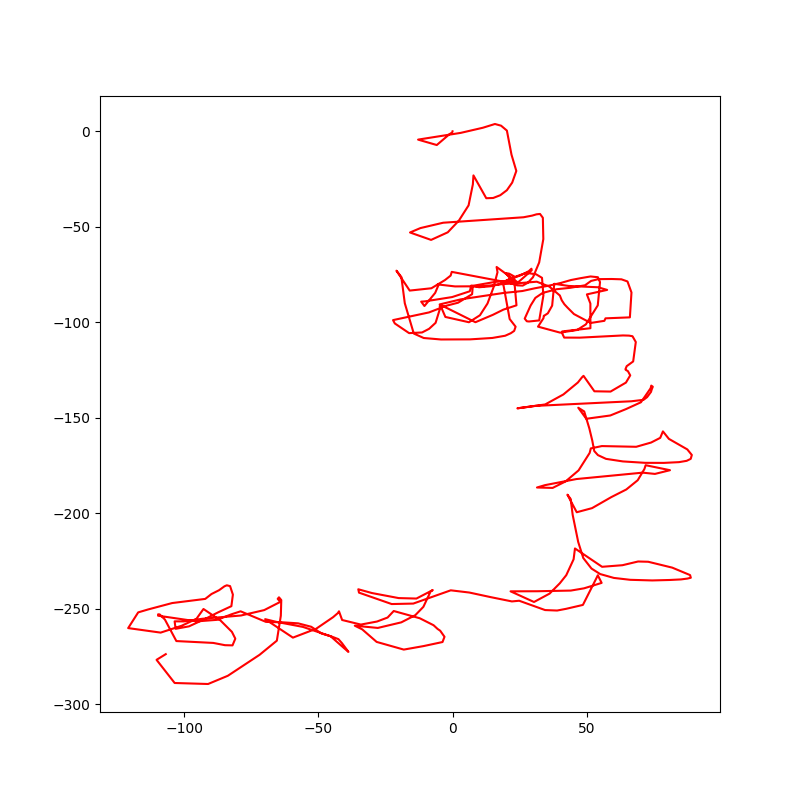

In [19]:
# Predict a character and plot the result.
pi_temperature = 2.5 # seems to work well with rather high temperature (2.5)
sigma_temp = 0.1 # seems to work well with low temp

p = zero_start_position()
sketch = [p.reshape(3,)]

for i in range(400):
    params = decoder.predict(p.reshape(1,1,3))
    p = mdn.sample_from_output(params[0], OUTPUT_DIMENSION, NUMBER_MIXTURES, temp=pi_temperature, sigma_temp=sigma_temp)
    sketch.append(p.reshape((3,)))

sketch = np.array(sketch)
decoder.reset_states()

sketch.T[2] = cutoff_stroke(sketch.T[2])
draw_strokes(sketch, factor=0.5)
plot_sketch(sketch)

## Converting to TensorFlow Lite

We will now convert the keras model into a tflite model. This primarily uses boilerplate code which invokes the TFLiteConverter class and writes the generated model to file. This conversion currently outputs a significant amount of arithmetic conversion errors. From other posts online, this seems to be a superficial issue with converting from 32 bit ints to 64 bit ints and does not affect the validity of the conversion.

In [20]:
# Following code converts high level keras model to a .tflite file 
import tensorflow as tf
# The decoder is used in runtime so this is what we are making the tflite file from
converter = tf.lite.TFLiteConverter.from_keras_model(decoder)

tflite_model = converter.convert()
# Saves converted file to this folder
tflite_model_name = '3-kanji-generation-lite.tflite'
with open(tflite_model_name, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp9rflq6e7/assets


INFO:tensorflow:Assets written to: /tmp/tmp9rflq6e7/assets
2024-06-14 16:20:40.336897: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-06-14 16:20:40.366477: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-06-14 16:20:40.692512: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp9rflq6e7
2024-06-14 16:20:40.718055: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-06-14 16:20:40.718097: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp9rflq6e7
2024-06-14 16:20:40.823980: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-06-14 16:20:40.834518: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-06-14 16:20:41.191556: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

## Predicting using the TensorFlow Lite Model

To make predictions using the tflite runtime, we use the interpreter class. Primarily, this is boilerplate code provided from the tensorflow tutorials. Importantly as our has a model dynamic input shape (as indicated by us defining the keras model with a first layer with batch_input_shape=(None, 1)) we must define the input tensor manually using resize_tensor_input. Now, we will test the tflite model on our original training data and compare it to the keras model.

In [21]:
# Load the TFLite model and allocate tensors.
# Note that it assumes we are loading the model just saved to the current folder
# to interpret from a model we have just generated, use model_content=tflite_model as the parameter instead
interpreter = tf.lite.Interpreter(model_path=tflite_model_name) 

# Resize input shape for dynamic shape model and allocate tensor
interpreter.resize_tensor_input(interpreter.get_input_details()[0]['index'], (1,1,3))
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


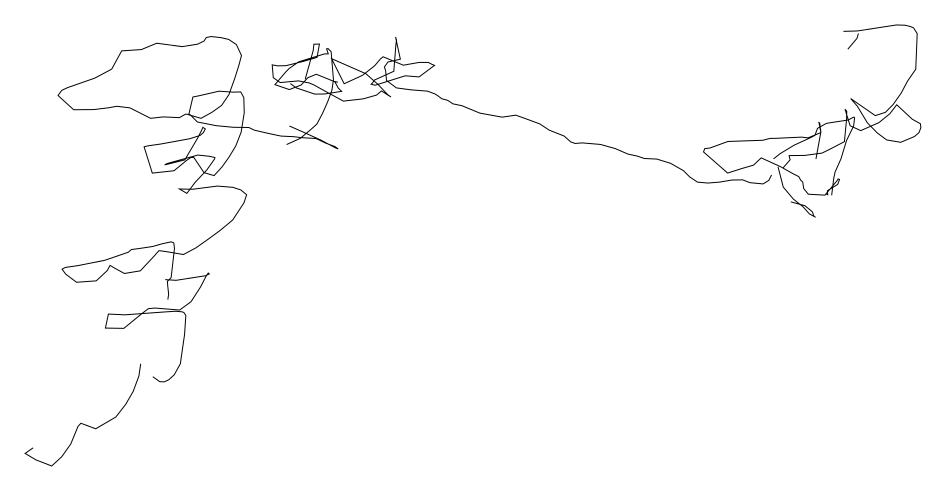

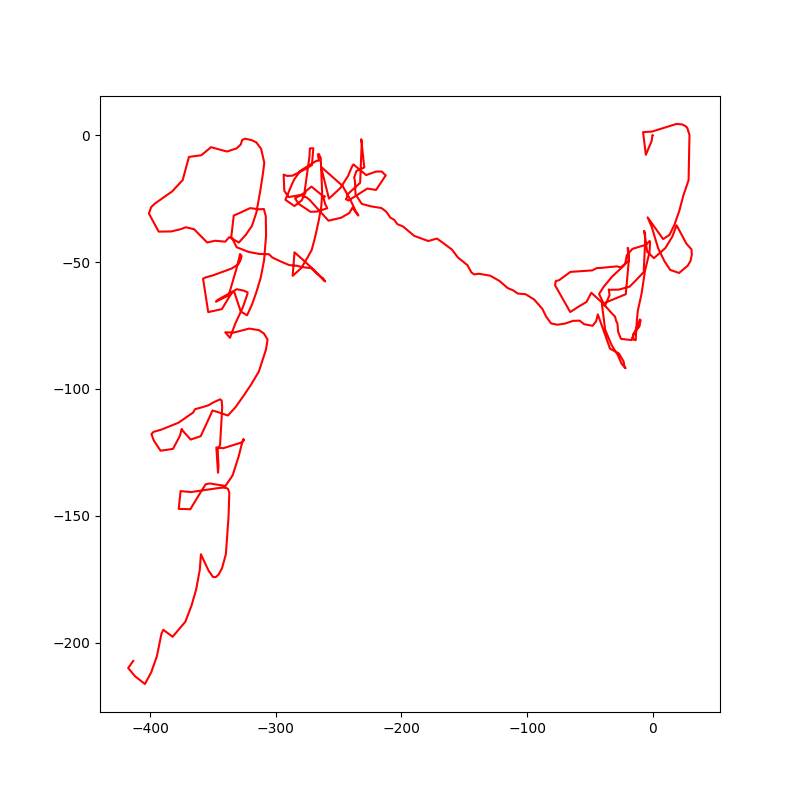

In [22]:
p = zero_start_position()
sketch = [p.reshape(3,)]

for i in range(400):
        
    # Test the model on our defined testing set
    # Important: remember we use the x_test_pred as it has correct dimension for predictions, x_test has dimension for graphing
    interpreter.set_tensor(input_details[0]['index'], p.reshape(1,1,3).astype(np.float32))
    
    # Uses the interpreter to make the same predictions as our keras model
    interpreter.invoke()
    
    # The function `get_tensor()` returns a copy of the tensor data.
    params = interpreter.get_tensor(output_details[0]['index'])

    p = mdn.sample_from_output(params[0], OUTPUT_DIMENSION, NUMBER_MIXTURES, temp=pi_temperature, sigma_temp=sigma_temp)
    sketch.append(p.reshape((3,)))

sketch = np.array(sketch)
decoder.reset_states()

sketch.T[2] = cutoff_stroke(sketch.T[2])
draw_strokes(sketch, factor=0.5)
plot_sketch(sketch)
# The model clearly successfully predicts our dataset.